In [15]:
import jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist
import copy
from dataclasses import dataclass, field
from jax import random
import jax
from numpyro.infer import MCMC, NUTS, Predictive
import itertools

rng_key = random.PRNGKey(12345)

In [16]:
class TeamMember:

    def __init__(self, id, theta_array):
        self.id = id
        self.theta_values = theta_array
        self.N = 0
        self.reward = 0

    def update(self, achieved_reward):
        self.N += 1
        self.reward += achieved_reward

    def __repr__(self):
        return f"ID: {self.id} | theta values: {self.theta_values} | Used number: {self.N} | Obtained rewards: {self.reward}"

class Task:

    def __init__(self, id, delta):
        self.id = id
        self.delta = delta
        
    def __repr__(self):
        return f"ID: {self.id} | delta value: {self.delta}"

class Environment:
    
    def __init__(self, thetas: np.array, deltas: list):

        self.deltas = deltas # defines the task complexity for the simulation
        self.num_team_members = len(thetas)

        self.team_members = []
        for i in range(len(thetas)):
            self.team_members.append(TeamMember(i, thetas[i]))
        
        # saved states(initiated with dummy states)
        self.used_member_combination_history = [[0, 1, 2]]
        self.accumulated_rewards = [[0, 0, 0]]
        self.completed_tasks_history = [[0, 1, 2]]
    
    def get_random_task_pack(self, pack_size=3, random_difficulty = False):

        if not(random_difficulty):
            # Here tasks always comes with same difficulty setting
            return [ Task(c, self.deltas[c]) for c in range(len(self.deltas))]
        else:
            # Here tasks are randomly generated with random difficulties (but ordered based on the difficulty value)
            random_tasks = [ Task(self.deltas.index(c), c) for c in np.random.choice(self.deltas, pack_size)]
            return random_tasks


In [17]:
def rasch(b, d):
    # in the ranges of b, d where both need to be between 0 and 1, range of rasch is 0.7310586 0.26894143
    value = jnp.exp(b - d) / (1 + jnp.exp(b-d))
    return value

def model(task_difficulty_indices, team_assignments, difficulty_values, obs=None):
    '''
        Environment Model
    '''

    # Sample latent ability parameters for 3 team members and 3 difficulty levels.
    theta = numpyro.sample("theta", dist.Beta(1, 1).expand([3, 3]))

    assert task_difficulty_indices.shape[1] == 3
    assert team_assignments.shape[1] == 3

    # Get ability b for each task based on team assignment and task difficulty index.
    b = theta[team_assignments, task_difficulty_indices]

    # Map difficulty indices to true difficulty values.
    d_true = difficulty_values[task_difficulty_indices]

    # Compute probabilities using the Rasch function.
    probs = rasch(b, d_true)

    with numpyro.plate("samples", task_difficulty_indices.shape[0]): 
        numpyro.sample("obs", dist.Bernoulli(probs=probs).to_event(1), obs=obs)

def estimate_parameters(environment: Environment, warm_up=1000, num_samples=10, print_summary=False, warm_start_params=None):
    """Estimate the parameters of the model using MCMC"""
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=warm_up, num_samples=num_samples)

    # building posterior
    mcmc.run(rng_key,   obs = jnp.array(environment.accumulated_rewards), 
                        team_assignments = jnp.array(environment.used_member_combination_history), 
                        task_difficulty_indices = jnp.array(environment.completed_tasks_history), 
                        difficulty_values = jnp.array(environment.deltas),
                        init_params=warm_start_params)
    
    if(print_summary):
        mcmc.print_summary()
        print()

    new_warm_start_params = {'theta': mcmc.get_samples()['theta'].mean(axis=0)}
    return mcmc, new_warm_start_params

class ContextualThompsonSampling:
    @classmethod
    def get_team_member_assignments(cls, mcmc: MCMC, task_difficulties, task_difficulty_values) -> int:
        
        best_assignment = None
        
        score_list = []

        assert task_difficulties.shape[1] == 3

        sample_thetas = mcmc.get_samples()['theta']
        # sample a random theta samples
        n, _, _ = sample_thetas.shape
        # sample_theta = sample_thetas[np.random.randint(0, n)]
        sample_theta = sample_thetas.mean(axis=0)
        
        # Evaluate each candidate assignment (permutation of team members).
        for assignment in itertools.permutations(range(3), 3):

            candidate_team_assignments = jnp.array([list(assignment)])
            
            assert candidate_team_assignments.shape[1] == 3
            
            # Get ability b for each task based on team assignment and task difficulty index.
            b = sample_theta[candidate_team_assignments, task_difficulties]
            d_true = task_difficulty_values[task_difficulties]

            p_success = rasch(b, d_true)[0]
            
            # Compute outcome using the Rasch function.
            outcome = jax.random.binomial(rng_key, 1, p_success)

            score = jnp.sum(outcome)
            score_list.append((score, outcome, p_success, assignment))

        score_list.sort(key=lambda x: x[0], reverse=True)

        max_list = [score_list[0]]
        for item in score_list[1:]:
            if item[0] == max_list[-1][0]:
                max_list.append(item)
            else:
                break

        best_assignment = max_list[np.random.randint(0, len(max_list))]

        # print(f"Best assignment: {best_assignment} | Best score: {best_score} | True reward: {true_reward_lst}")
        # print()
        return best_assignment[-1], best_assignment[0], best_assignment[1]
    

In [18]:
NUMBER_OF_TRIALS = 200
DELTAS = [0.1, 0.2, 0.3] # Task complexities
WARM_UP = 1000
NUM_SAMPLES = 1000

ESTIMATION_INTERVAL = 20

# Team member true capabilities for each type of task
THETAS = [[0.9, 0.1, 0.1],
          [0.1, 0.9, 0.1],
          [0.1, 0.1, 0.9]]

environment = Environment(np.array(THETAS), DELTAS)
mcmc, _ = estimate_parameters(environment, WARM_UP, NUM_SAMPLES)
warm_start_params = None

sample: 100%|██████████| 2000/2000 [00:00<00:00, 3027.14it/s, 7 steps of size 5.94e-01. acc. prob=0.89]


In [19]:
for i in range(NUMBER_OF_TRIALS):
    
    if(i%ESTIMATION_INTERVAL==ESTIMATION_INTERVAL-1):
        print(i)
        mcmc, warm_start_params = estimate_parameters(environment, WARM_UP, NUM_SAMPLES)

    # Generate a random task set
    tasks = environment.get_random_task_pack(random_difficulty=False)
    task_types = [f.id for f in tasks]

    # Get the best assignment and the score predicted for that assignment
    best_assignment, best_score, true_reward_lst = ContextualThompsonSampling.get_team_member_assignments(
                                                                                    mcmc, 
                                                                                    jnp.expand_dims(jnp.array(task_types), axis=0), 
                                                                                    jnp.array(environment.deltas))
    
    environment.accumulated_rewards.append(true_reward_lst)
    environment.used_member_combination_history.append(tuple(best_assignment))
    environment.completed_tasks_history.append(task_types)

mcmc, _ = estimate_parameters(environment, WARM_UP, NUM_SAMPLES, print_summary=True)
# predictive_dist = Predictive(model, mcmc.get_samples())

19


sample: 100%|██████████| 2000/2000 [00:00<00:00, 2688.61it/s, 7 steps of size 5.54e-01. acc. prob=0.90]


39


sample: 100%|██████████| 2000/2000 [00:00<00:00, 2534.17it/s, 7 steps of size 5.21e-01. acc. prob=0.90]


59


sample: 100%|██████████| 2000/2000 [00:00<00:00, 2386.74it/s, 7 steps of size 4.90e-01. acc. prob=0.91]


79


sample: 100%|██████████| 2000/2000 [00:00<00:00, 2079.45it/s, 7 steps of size 4.77e-01. acc. prob=0.91]


99


sample: 100%|██████████| 2000/2000 [00:01<00:00, 1967.71it/s, 15 steps of size 4.56e-01. acc. prob=0.93]


119


sample: 100%|██████████| 2000/2000 [00:01<00:00, 1997.69it/s, 15 steps of size 4.35e-01. acc. prob=0.93]


139


sample: 100%|██████████| 2000/2000 [00:01<00:00, 1806.22it/s, 7 steps of size 4.47e-01. acc. prob=0.93]


159


sample: 100%|██████████| 2000/2000 [00:01<00:00, 1723.00it/s, 31 steps of size 4.62e-01. acc. prob=0.92]


179


sample: 100%|██████████| 2000/2000 [00:01<00:00, 1620.33it/s, 31 steps of size 4.27e-01. acc. prob=0.93]


199


sample: 100%|██████████| 2000/2000 [00:01<00:00, 1697.74it/s, 31 steps of size 4.36e-01. acc. prob=0.93]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
theta[0,0]      0.24      0.15      0.22      0.00      0.45   1057.59      1.00
theta[0,1]      0.96      0.04      0.97      0.91      1.00   1048.48      1.00
theta[0,2]      0.32      0.22      0.28      0.00      0.62   1618.88      1.00
theta[1,0]      0.13      0.11      0.10      0.00      0.29   1508.34      1.00
theta[1,1]      0.95      0.05      0.96      0.89      1.00   1194.89      1.00
theta[1,2]      0.25      0.16      0.22      0.00      0.48   1325.26      1.00
theta[2,0]      0.13      0.12      0.09      0.00      0.30   1046.31      1.00
theta[2,1]      0.95      0.05      0.96      0.89      1.00   1278.33      1.00
theta[2,2]      0.20      0.14      0.17      0.00      0.39   1397.75      1.00

Number of divergences: 0



In [20]:
from collections import Counter

Counter(environment.used_member_combination_history[1:])

Counter({(0, 2, 1): 53,
         (0, 1, 2): 47,
         (1, 0, 2): 38,
         (2, 0, 1): 35,
         (2, 1, 0): 17,
         (1, 2, 0): 10})

In [50]:
best_assignment, best_score, true_reward_lst = ContextualThompsonSampling.get_team_member_assignments(
                                                                                        mcmc,
                                                                                        jnp.expand_dims(jnp.array([0, 1, 2]), axis=0),                                                                                        
                                                                                        jnp.array(environment.deltas))


print(best_assignment)

(0, 2, 1)


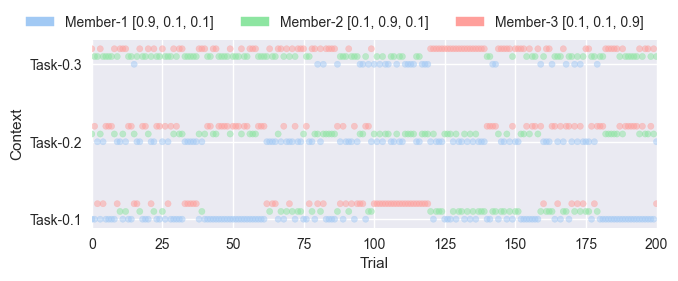

In [51]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")


# Plot a scatter plot of which arm was chosen at each time step
arm_descriptions = [f"Member-{i+1} {capability}" for i, capability in enumerate(THETAS)]
arm_index = [i for i in range(len(arm_descriptions))]
contexts = [0, 1, 2]
context_descriptions = [f"Task-{i}" for i in DELTAS]
arm_colors = ['#a1c9f4', '#8de5a1', '#ff9f9b', '#d0bbff', '#fffea3', '#b9f2f0']

# Plot the arm choices
fig, ax = plt.subplots(1, 1, figsize=(7, 3))

for difficulty in contexts:
    x, y, c = [], [], []
    for i in range(len(environment.used_member_combination_history)):
        x.append(i)
        y.append(difficulty + environment.used_member_combination_history[i][difficulty] * 0.1)
        c.append(arm_colors[environment.used_member_combination_history[i][difficulty]])
    ax.scatter(x, y, c=c, s=20, alpha=0.5)
    
ax.set_yticks(range(len(contexts)), context_descriptions)
ax.set_ylabel("Context")
ax.set_xlabel("Trial")
ax.set_xlim([0, 200])

handles = []
for arm in arm_index:
    h = mpatches.Patch(color=arm_colors[arm], label=arm_descriptions[arm])
    handles.append(h)
plt.legend(handles=handles, bbox_to_anchor=(1., 1.2), loc="upper right", ncols=4)
plt.tight_layout()
plt.show()

In [23]:
# DELTAS = [0.3, 0.5, 0.8]

# THETAS = [[0.3, 0.5, 0.8],      # Team Member 1
#           [0.8, 0.3, 0.5],      # Team Member 2
#           [0.5, 0.8, 0.3] ]     # Team Member 3

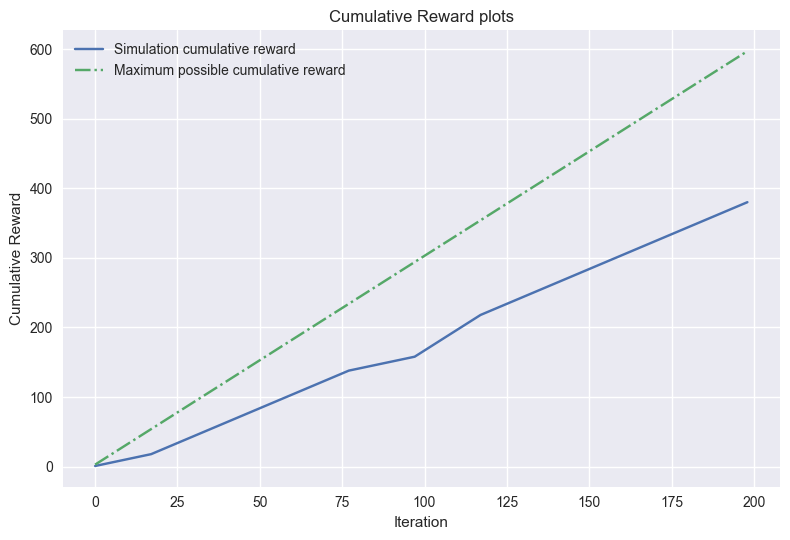

In [24]:
y = np.cumulative_sum(np.array(environment.accumulated_rewards[2:]).sum(axis=1))
x = np.array(range(len(y)))

# first plot with X and Y data
plt.plot(x, y, label="Simulation cumulative reward")

x1 = np.array(range(len(y)))
y1 = np.cumulative_sum(np.ones_like(np.array(environment.accumulated_rewards[2:])).sum(axis=1))

# second plot with x1 and y1 data
plt.plot(x1, y1, '-.', label="Maximum possible cumulative reward")

plt.xlabel("Iteration")
plt.ylabel("Cumulative Reward")
plt.title('Cumulative Reward plots')
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()